In [1]:
from minisom import MiniSom
from pathlib import Path
# from rastertools import download, raster_clip, utils
import numpy as np
import rasterio
import os
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans

In [11]:
%load_ext autoreload
%autoreload 2

# Load Data

In [194]:
grid3_gdf = gpd.read_file('datasets\\NGA_population_v2_0_admin\\GRID3_NGA_population_v2_0_admin_Ward.shp')
projected_gdf = grid3_gdf.to_crs(epsg=3395)
projected_gdf["log_pop"] = np.log10(projected_gdf["mean"]+1)
projected_gdf["ward_area"] = projected_gdf["geometry"].area/ 1e6
projected_gdf["pop_density"] = (projected_gdf["mean"]+1)/projected_gdf["ward_area"]
projected_gdf["log_pop_density"] = np.log10(projected_gdf["pop_density"])
# projected_gdf["log_pop_density_adjusted"] = (projected_gdf["log_pop_density"] - np.mean(projected_gdf["log_pop_density"]))/np.std(projected_gdf["log_pop_density"])
# projected_gdf = projected_gdf.sort_values(by="pop_density")
# grid3_gdf.head(2)

In [113]:
landcover_gdf = gpd.read_file("datasets/geonetwork_landcover_nga_gc_adg.zip")
projected_landcover_gdf = landcover_gdf.to_crs(epsg=3395)
projected_landcover_gdf['landcover_area']=projected_landcover_gdf['geometry'].area

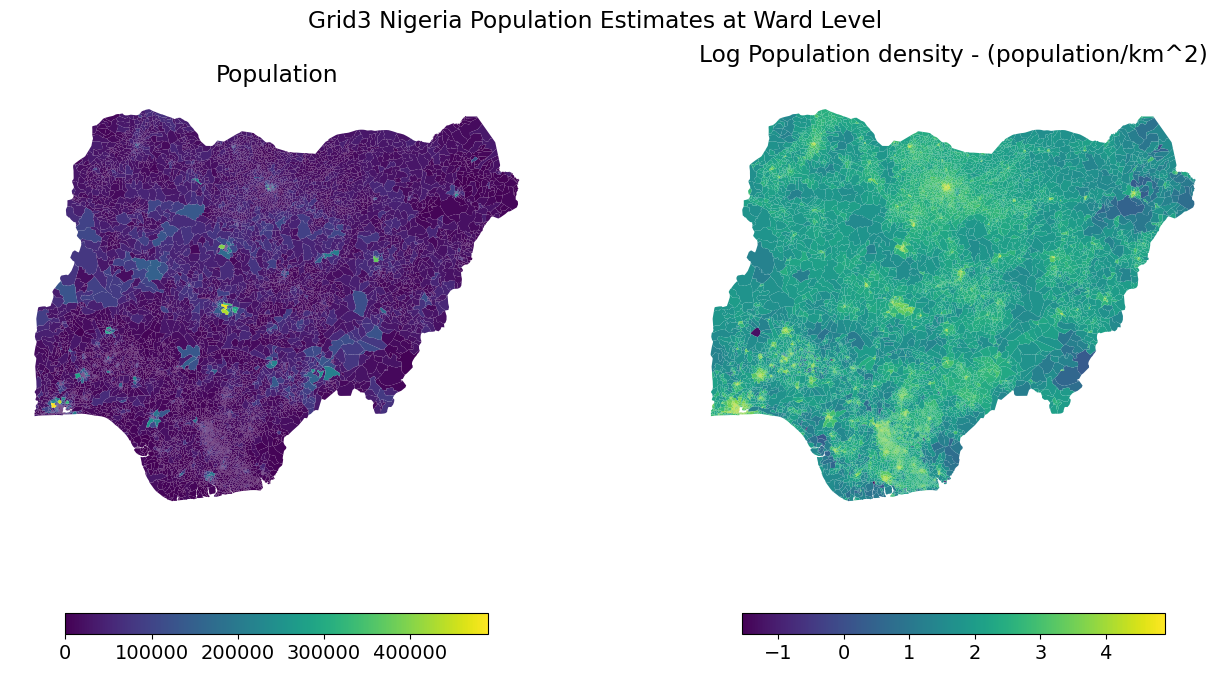

In [198]:
plt.rc('font', size=14) 

fig, axs = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Grid3 Nigeria Population Estimates at Ward Level')
projected_gdf.plot("mean", ax=axs[0], legend=True, legend_kwds={
        "location":"bottom",
        "shrink":.75
    })
axs[0].set_title("Population")
axs[0].axis('off')

projected_gdf.plot("log_pop_density", ax=axs[1], legend=True, legend_kwds={
        "location":"bottom",
        "shrink":.75
    })
axs[1].set_title("Log Population density - (population/km^2)")
axs[1].axis('off')

plt.show()

# Join Data

In [118]:
joined_gdf = gpd.sjoin(projected_landcover_gdf, projected_gdf, how="inner", op='intersects')
joined_gdf["pct_area"] = joined_gdf["landcover_area"]/joined_gdf["ward_area"]
# aggregated_gdf = joined_gdf.groupby(['id', 'GRIDCODE'])['landcover_area'].sum().reset_index(name='total_area')
# aggregated_gdf['percentage'] = aggregated_gdf.apply(lambda row: (row['total_area'] / projected_gdf.loc[projected_gdf['id'] == row['id'], 'ward_area'].values[0]), axis=1)

c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [121]:
joined_gdf = joined_gdf[["GRIDCODE","geometry", "id", "mean", "ward_area", "landcover_area",
 "pop_density", "log_pop_density", "pct_area"]]

joined_gdf.head()


,GRIDCODE,geometry,id,mean,ward_area,landcover_area,pop_density,log_pop_density,pct_area
0,14,"POLYGON ((614498.260 1551379.937, 615208.518 1...",u_boundary_wards.7106,58790.8595,1.818112e+08,1.162085e+06,0.000323,-3.490303,0.006392
1,150,"POLYGON ((612102.589 1550113.867, 612102.589 1...",u_boundary_wards.7106,58790.8595,1.818112e+08,2.923144e+06,0.000323,-3.490303,0.016078
2,200,"POLYGON ((614885.576 1551063.414, 615194.797 1...",u_boundary_wards.7106,58790.8595,1.818112e+08,3.914954e+05,0.000323,-3.490303,0.002153
3,150,"POLYGON ((616431.680 1550746.894, 616431.680 1...",u_boundary_wards.7106,58790.8595,1.818112e+08,2.056920e+06,0.000323,-3.490303,0.011313
4,20,"POLYGON ((615194.797 1550113.867, 615504.018 1...",u_boundary_wards.7106,58790.8595,1.818112e+08,7.577852e+06,0.000323,-3.490303,0.041680


In [125]:
pivotdf = joined_gdf.pivot_table(index="id", columns="GRIDCODE", values="pct_area", aggfunc='sum').fillna(0)
pivotdf.head()

GRIDCODE,11,14,20,30,32,40,41,60,110,120,...,143,150,160,170,180,190,200,201,202,210
id,,,,,,,,,,,,,,,,,,,,,
u_boundary_wards.1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,934.178065,3.694743,0.124278,...,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
u_boundary_wards.10,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,30.14573,0.000000,0.0,0.0,0.000000
u_boundary_wards.100,0.0,6.502976,0.373444,0.538149,0.0,0.0,0.0,0.000000,0.031385,0.000000,...,0.004254,0.001595,0.0,0.0,0.0,0.00000,0.049998,0.0,0.0,0.898776
u_boundary_wards.1000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2516.665341,0.000000,132.434637,...,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
u_boundary_wards.1001,0.0,0.002747,0.000000,0.431385,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,109.159356,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000


# Train SOM

In [201]:
pop_feature = projected_gdf["mean"].values.reshape(-1,1)
log_pop_feature = projected_gdf["log_pop_density"].values.reshape(-1,1)
# log_pop_adjusted_feature = projected_gdf["log_pop_density_adjusted"].values.reshape(-1,1)

In [202]:
x, y = 1, 3
som_3 = MiniSom(x, y, input_len=1, sigma=1.0, learning_rate=0.5)
som_3.train_random(log_pop_feature, 200)

x, y = 2, 3
som_6 = MiniSom(x, y, input_len=1, sigma=1.0, learning_rate=0.5)
som_6.train_random(log_pop_feature, 200)

x, y = 3, 3
som_9 = MiniSom(x, y, input_len=1, sigma=1.0, learning_rate=0.5)
som_9.train_random(log_pop_feature, 200)

c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\minisom.py:160: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


In [142]:
def coordinates_to_cluster_label(coordinates):
    x, y = coordinates
    return x * 3 + y + 1

def get_winner_coordinates(data_point, som):
    x, y = som.winner(data_point)
    return (x, y)

# Plot

In [203]:
winning_coordinates_3 = [get_winner_coordinates(dp, som_3) for dp in log_pop_feature]
winning_coordinates_6 = [get_winner_coordinates(dp, som_6) for dp in log_pop_feature]
winning_coordinates_9 = [get_winner_coordinates(dp, som_9) for dp in log_pop_feature]

projected_gdf['cluster_3'] = [coordinates_to_cluster_label(coord) for coord in winning_coordinates_3]
projected_gdf['cluster_6'] = [coordinates_to_cluster_label(coord) for coord in winning_coordinates_6]
projected_gdf['cluster_9'] = [coordinates_to_cluster_label(coord) for coord in winning_coordinates_9]

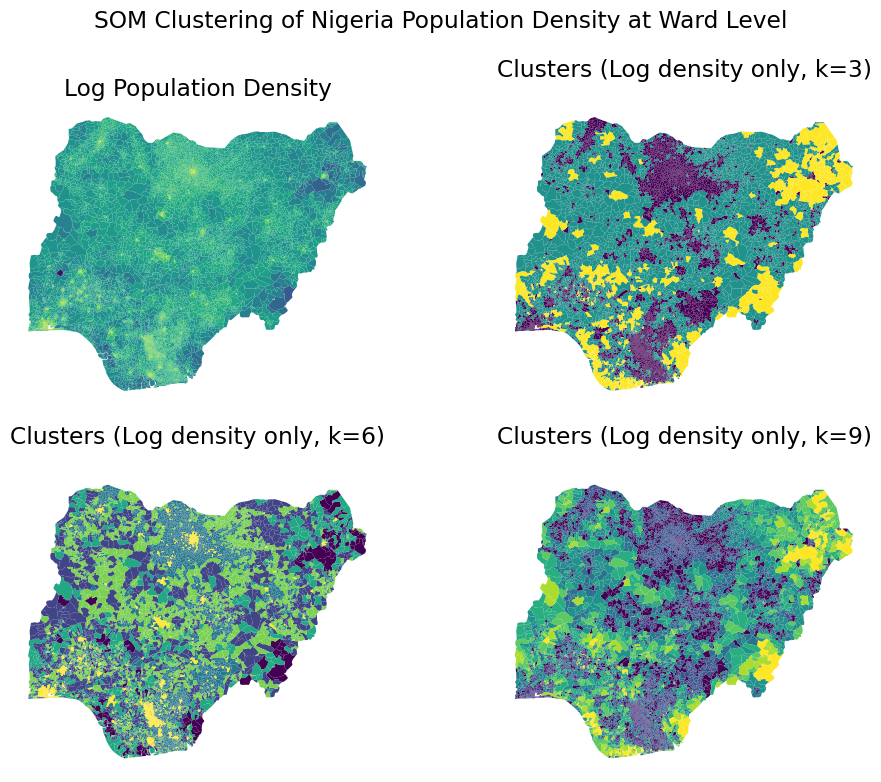

In [215]:
plt.rc('font', size=14) 

fig, axs = plt.subplots(2,2, figsize=(10,8))
axs = np.ravel(axs)
fig.suptitle('SOM Clustering of Nigeria Population Density at Ward Level')
projected_gdf.plot("log_pop_density", ax=axs[0], legend=False, legend_kwds={
        "location":"bottom",
        "shrink":.75
    })
axs[0].set_title("Log Population Density")
axs[0].axis('off')

projected_gdf.plot("cluster_3", ax=axs[1], categorical=True, legend=False, cmap='viridis')
axs[1].set_title("Clusters (Log density only, k=3)")
axs[1].axis('off')

projected_gdf.plot("cluster_6", ax=axs[2], categorical=True, legend=False, cmap='viridis')
axs[2].set_title("Clusters (Log density only, k=6)")
axs[2].axis('off')

projected_gdf.plot("cluster_9", ax=axs[3], categorical=True, legend=False, cmap='viridis')
axs[3].set_title("Clusters (Log density only, k=9)")
axs[3].axis('off')

plt.tight_layout()
plt.show()

# Kmeans

In [210]:
feature = np.nan_to_num(log_pop_feature)
kmeans3 = KMeans(n_clusters=3, random_state=0).fit(feature)
kmeans6 = KMeans(n_clusters=6, random_state=0).fit(feature)
kmeans9 = KMeans(n_clusters=9, random_state=0).fit(feature)

c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [212]:
projected_gdf['cluster_3_kmeans'] = kmeans3.labels_
projected_gdf['cluster_6_kmeans'] = kmeans6.labels_
projected_gdf['cluster_9_kmeans'] = kmeans9.labels_

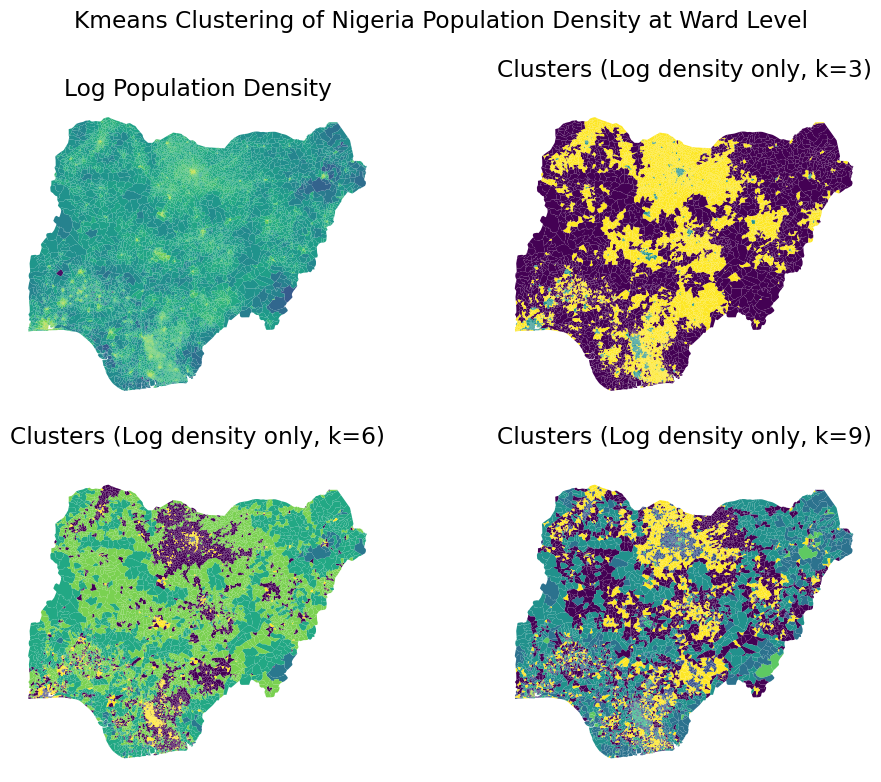

In [214]:
plt.rc('font', size=14) 

fig, axs = plt.subplots(2,2, figsize=(10,8))
axs = np.ravel(axs)
fig.suptitle('Kmeans Clustering of Nigeria Population Density at Ward Level')

projected_gdf.plot("log_pop_density", ax=axs[0], legend=False, legend_kwds={
        "location":"bottom",
        "shrink":.75
    })
axs[0].set_title("Log Population Density")
axs[0].axis('off')

projected_gdf.plot("cluster_3_kmeans", ax=axs[1], categorical=True, legend=False, cmap='viridis')
axs[1].set_title("Clusters (Log density only, k=3)")
axs[1].axis('off')

projected_gdf.plot("cluster_6_kmeans", ax=axs[2], categorical=True, legend=False, cmap='viridis')
axs[2].set_title("Clusters (Log density only, k=6)")
axs[2].axis('off')

projected_gdf.plot("cluster_9_kmeans", ax=axs[3], categorical=True, legend=False, cmap='viridis')
axs[3].set_title("Clusters (Log density only, k=9)")
axs[3].axis('off')

plt.tight_layout()
plt.show()